In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as la
import scipy.sparse as sp
import cvxopt
import itertools
import scipy.ndimage as ndi
import skimage.transform as sktf
from scipy.optimize import minimize_scalar

In [243]:
sigma = 10
l = np.array((1,1))
sz = 10
num = 2*10*sz
x = np.linspace(-sz, sz, num)
y = x
xv, yv = np.meshgrid(x, y)
grid = np.dstack((xv, yv))
#grid = np.array(list(itertools.product(x, y)))
#grid = np.empty(x.size*y.size, dtype=object)
#grid[:] = list(itertools.product(x, y))
dotgrid = grid@l
#grid = grid.reshape(x.size, y.size)
norms = la.norm(grid, axis=2)**2

In [244]:
img = np.exp(-2j*np.pi*dotgrid)*np.exp(-norms/(2*sigma**2))

In [245]:
plt.imshow(np.imag(img))
plt.show()

In [246]:
rad = sktf.radon(np.imag(img), circle=False)

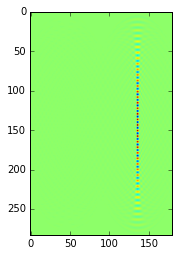

In [247]:
plt.imshow(rad)
plt.show()

In [248]:
irad = sktf.iradon(rad, circle=False)

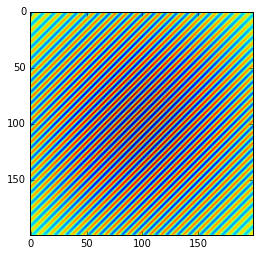

In [249]:
plt.imshow(irad)
plt.show()

In [250]:
def ql(the, p):
    the_ort = np.array((-the[1], the[0]))
    
    s1 = 1/np.pi*np.exp(-2*sigma**2*np.pi**2*la.norm(l)**2)
    
    e1 = -2*np.pi*sigma**2*np.dot(l, the_ort)**2
    e2 = -2*np.pi*1j*p*np.dot(l, the)
    e3 = -p**2/(2*sigma**2)
    f1 = np.exp(e1+e2+e3)
    f2 = 1j*p/(2*np.pi*sigma**2) - np.dot(l, the)
    f3 = np.sqrt(2*sigma**2*np.pi)
    f4 = scipy.special.erf(np.sqrt(2*np.pi**2*sigma**2)*f2)
    
    s2 = f1*f2*f3*f4
    #print()
    return s1 + s2

In [251]:
def radf(the, s):
    the_ort = np.array((-the[1], the[0]))
    e1 = -2j*np.pi*s*np.dot(l, the)
    e2 = -s**2/(2*sigma**2)
    e3 = -2*sigma**2*np.pi**2*np.dot(l, the_ort)**2
    #return (np.exp(e1), np.exp(e2), np.exp(e3), np.exp(e1+e2+e3))
    return np.sqrt(2*sigma**2*np.pi) * np.exp(e1+e2+e3)

In [252]:
angles = np.arange(180)
rangles = angles/180*np.pi
thetas = np.vstack((np.cos(rangles), -np.sin(rangles))).transpose()
ps = x
#ps = np.arange(-30, 30)
qls = np.empty((ps.size, thetas.shape[0]), dtype=complex)
for thi, the in enumerate(thetas):
    for pi, p in enumerate(ps):
        qls[pi, thi] = ql(the, p)

In [253]:
radfs = np.empty((ps.size, thetas.shape[0]), dtype=complex)
for thi, the in enumerate(thetas):
    for pi, p in enumerate(ps):
        radfs[pi, thi] = radf(the, p)

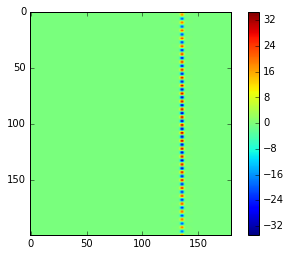

In [254]:
plt.imshow(np.imag(qls))
plt.colorbar()
plt.show()
#np.real(qls[:,0])

In [266]:
#drad = sktf.iradon(np.imag(qls), circle=False, filter=None)
drad = sktf.iradon(np.imag(radfs), circle=False, filter=None)
#drad = sktf.iradon(qls, circle=False)

In [267]:
f, (a1, a2) = plt.subplots(1,2)
a1.imshow(drad)
a2.imshow(np.imag(img))
plt.show()

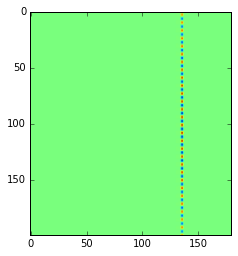

In [265]:
plt.imshow(np.imag(radfs))
plt.show()

In [201]:
plt.plot(np.real(radfs)[30,:])
plt.show()

In [182]:
res = np.empty((thetas.shape[0], 4),dtype=complex)
for i, the in enumerate(thetas):
    res[i] = radf(the, -30)

/home/alex/.local/lib/python3.5/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


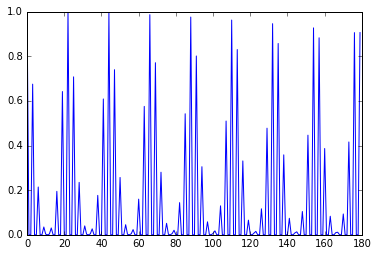

In [185]:
#plt.plot(np.real(res[:,0]))
#plt.plot(res[:,1])
plt.plot(res[:,2])
plt.show()

In [3]:
np.arange(-5,5)


array([25, 16,  9,  4,  1,  0,  1,  4,  9, 16])

In [55]:
def move_right(x,y):
    return x+1, y

def move_down(x,y):
    return x,y-1

def move_left(x,y):
    return x-1,y

def move_up(x,y):
    return x,y+1

moves = [move_right, move_down, move_left, move_up]
def gen_points():
    from itertools import cycle
    _moves = cycle(moves)
    n = 1
    pos = 0,0
    times_to_move = 1

    yield n,pos

    while True:
        for _ in range(2):
            move = next(_moves)
            for _ in range(times_to_move):
                #if n >= end:
                 #   return
                pos = move(*pos)
                n+=1
                yield n,pos

        times_to_move+=1

#g=gen_points()
#for k in range((2*5+1)**2):
 #   print(next(g))

In [70]:
g=gen_points()
K = 10
num = 200
x = np.linspace(0, 1, num, endpoint=False)
y = x
xv, yv = np.meshgrid(x, y)
grid = np.dstack((xv, yv))
#grid = np.array(list(itertools.product(x, y)))
#grid = np.empty(x.size*y.size, dtype=object)
#grid[:] = list(itertools.product(x, y))
#dotgrid = grid@l
#grid = grid.reshape(x.size, y.size)
#norms = la.norm(grid, axis=2)**2
support = np.array([(0,0),(0.5,0.5),(0,0.5),(0.5,0)])
weights = 1*np.array([1, -1,1,-1])
#support = np.array([(0,0), (0.5,0.5)])
#weights = 1*np.array([1,-1])
uk = np.zeros((num,num),dtype=complex)
#for m1 in np.arange(-K, K+1):
#    for m2 in np.arange(-K, K+1):
for i in range((2*K+1)**2):
    _,(m1,m2)=next(g)
    w = 0
    for i in range(len(support)):
        w += weights[i]*np.exp(-2j*np.pi*support[i]@(m1,m2))
    #print(m1, m2, w)
    #if m1+m2%2!=0:
    #if m1%2!=0:
    uk += w*np.exp(2j*np.pi*grid@(m1,m2))
#uk += -10*np.exp(2j*np.pi*grid@(K+1,K+1))
#uk = 100*np.ones((num,num),dtype=complex)

radr = sktf.radon(np.real(uk/num), circle=False)
radi = sktf.radon(np.imag(uk/num), circle=False)
rad = radr+1j*radi

while True:
    tv = np.sum(np.abs(rad))/rad.shape[0]/rad.shape[1]*np.sqrt(2)
    print(tv)
    if tv < np.sum(np.abs(weights)):
        print("success")
        break
    _,(m1,m2)=next(g)
        
    uk2 = np.exp(2j*np.pi*grid@(m1,m2))
    radr2 = sktf.radon(np.real(uk2/num), circle=False)
    radi2 = sktf.radon(np.imag(uk2/num), circle=False)
    rad2 = radr2+1j*radi2
    def f(x):
        return np.sum(np.abs(rad+x*rad2))/rad.shape[0]/rad.shape[1]*np.sqrt(2)
    res = minimize_scalar(f)
    uk += res.x*uk2
    rad += res.x*rad2
    print((m1,m2),res.x, res.fun)

#for rad in (radr, radi):
 #   print(np.sum(np.abs(rad))/rad.shape[0]/rad.shape[1]*np.sqrt(2))
print(np.sum(np.abs(rad))/rad.shape[0]/rad.shape[1]*np.sqrt(2))

6.17831703675163
(11, 10) 1.1694517136177225 6.173587843600826
6.173587843600826
(11, 9) 0.10781787305752533 6.173529558764164
6.173529558764164
(11, 8) 0.8589496225057971 6.170728814592051
6.170728814592051
(11, 7) -0.03565279369394185 6.170724341539092
6.170724341539092
(11, 6) 0.9093171775458724 6.16734647509072
6.16734647509072
(11, 5) -0.1864021073501579 6.167205262747649
6.167205262747649
(11, 4) 0.6672000525039327 6.165324202890494
6.165324202890494
(11, 3) -0.2346900375070644 6.165044712906186
6.165044712906186
(11, 2) 0.6153358453756816 6.163235188941091
6.163235188941091
(11, 1) -0.08779814138841237 6.163116395893439
6.163116395893439
(11, 0) 1.6536764508835016 6.151954304177842
6.151954304177842
(11, -1) -0.1879754267877456 6.151432160294141
6.151432160294141
(11, -2) 0.9325489036142186 6.147094073338249
6.147094073338249
(11, -3) -0.23007416625491198 6.14677648053084
6.14677648053084
(11, -4) 0.7189027595481247 6.144343477706495
6.144343477706495
(11, -5) -0.255743752690290

(-4, -12) -0.19597782929023075 5.979201252721214
5.979201252721214
(-5, -12) 0.9381071117896516 5.975886628488897
5.975886628488897
(-6, -12) -0.027366330457952802 5.97588416070707
5.97588416070707
(-7, -12) 1.0155658976123128 5.972059872678574
5.972059872678574
(-8, -12) 0.15645038537291234 5.9719768149293895
5.9719768149293895
(-9, -12) 1.1038892366349493 5.967948946894828
5.967948946894828
(-10, -12) 0.361756037498374 5.967498037060125
5.967498037060125
(-11, -12) 1.3952526922375963 5.96221793164639
5.96221793164639
(-12, -12) -0.014791017072495942 5.962217123741686
5.962217123741686
(-12, -11) 0.10556786388063762 5.96217209215617
5.96217209215617
(-12, -10) -0.3044403083231782 5.961630887378783
5.961630887378783
(-12, -9) 0.002961871471833089 5.961630843733749
5.961630843733749
(-12, -8) -0.02059258555289771 5.9616291279844775
5.9616291279844775
(-12, -7) 0.34269627437868794 5.961061495584231
5.961061495584231
(-12, -6) 0.1545987329367158 5.960941274979674
5.960941274979674
(-12, -

(-13, 5) -0.29136979208209235 5.777135064560412
5.777135064560412
(-13, 6) 1.2750189471099675 5.768494640756356
5.768494640756356
(-13, 7) -0.19825724780558251 5.768287911495677
5.768287911495677
(-13, 8) 0.8203936355406618 5.765178560296199
5.765178560296199
(-13, 9) -0.21703593105418398 5.76494403038467
5.76494403038467
(-13, 10) 0.2064768491050117 5.764733179544231
5.764733179544231
(-13, 11) 0.1680207798833375 5.7645740097951546
5.7645740097951546
(-13, 12) 0.6018291844734552 5.76294688004027
5.76294688004027
(-13, 13) 0.11513081017324672 5.762888611571247
5.762888611571247
(-12, 13) 0.07572720364247416 5.7628680690274585
5.7628680690274585
(-11, 13) -0.27812395846699955 5.762534501114607
5.762534501114607
(-10, 13) 0.3021610950602156 5.762101479420374
5.762101479420374
(-9, 13) -0.11687882376289095 5.762041405778373
5.762041405778373
(-8, 13) 0.24826234474186124 5.76174879675667
5.76174879675667
(-7, 13) 0.2123801367860533 5.761515485428193
5.761515485428193
(-6, 13) -0.0214319925

(-6, 14) -0.3257427664621908 5.716878804781445
5.716878804781445
(-5, 14) 1.2296871467941721 5.709858982048708
5.709858982048708
(-4, 14) 0.05532979109155879 5.7098468841421255
5.7098468841421255
(-3, 14) 0.42039931433650735 5.708636964285496
5.708636964285496
(-2, 14) 0.25131054267847525 5.708192204618355
5.708192204618355
(-1, 14) 0.3652119785249455 5.707464794467988
5.707464794467988
(0, 14) 0.0 5.707464794467988
5.707464794467988
(1, 14) 0.945700952407535 5.7020780885229785
5.7020780885229785
(2, 14) 0.047458535098108816 5.702060967150204
5.702060967150204
(3, 14) 0.8482805133668249 5.6968794306334445
5.6968794306334445
(4, 14) 0.1836017860047702 5.696756278203821
5.696756278203821
(5, 14) 1.1603143110361833 5.690343948318815
5.690343948318815
(6, 14) -0.3188627572734598 5.689908653252296
5.689908653252296
(7, 14) 1.3886738015214786 5.681060543483031
5.681060543483031
(8, 14) -0.3601657501730833 5.680334489012089
5.680334489012089
(9, 14) 0.8435151417887924 5.677492807208637
5.6774

(0, 15) 0.0 5.6429840282179375
5.6429840282179375
(1, 15) 0.060283201321376635 5.64295876197525
5.64295876197525
(2, 15) -0.03211073355672399 5.642951035084066
5.642951035084066
(3, 15) 0.19024949400120097 5.642630141222828
5.642630141222828
(4, 15) 0.005243857672683056 5.6426300246263015
5.6426300246263015
(5, 15) 0.1914214122153404 5.6424543706384505
5.6424543706384505
(6, 15) -0.04246260658186608 5.642446133041018
5.642446133041018
(7, 15) -0.1632826192905542 5.64231605982782
5.64231605982782
(8, 15) 0.11713909377020833 5.64223952150798
5.64223952150798
(9, 15) 0.08483479305204555 5.642207152557456
5.642207152557456
(10, 15) 0.3543502030745593 5.641693051911373
5.641693051911373
(11, 15) 0.056549630933373764 5.641678146868973
5.641678146868973
(12, 15) 0.010534672845399471 5.641677610678878
5.641677610678878
(13, 15) -0.011149604936015698 5.641677105008163
5.641677105008163
(14, 15) 0.15467864717642799 5.641594716819438
5.641594716819438
(15, 15) 0.04752029328097743 5.64158421677773

(-2, 16) 0.34466551739501233 5.619175824474325
5.619175824474325
(-1, 16) -0.036871001298647905 5.619168449208442
5.619168449208442
(0, 16) 0.0 5.619168449208442
5.619168449208442
(1, 16) 0.5059171250518847 5.617526123822099
5.617526123822099
(2, 16) 0.14421837638345225 5.6174190982214
5.6174190982214
(3, 16) 0.6061883288164962 5.613795261294881
5.613795261294881
(4, 16) 0.009786139515292573 5.613794873673279
5.613794873673279
(5, 16) 1.1131565014132763 5.60857288715534
5.60857288715534
(6, 16) -0.12783461732031262 5.608498379943615
5.608498379943615
(7, 16) 0.26400569831599485 5.608231253492625
5.608231253492625
(8, 16) 0.06844998590673897 5.608212313575412
5.608212313575412
(9, 16) 0.4449201256391508 5.607139978922178
5.607139978922178
(10, 16) 0.30376358385860824 5.60678337952003
5.60678337952003
(11, 16) 0.4875544482367094 5.605918580952192
5.605918580952192
(12, 16) -0.33651055155939336 5.605421770016927
5.605421770016927
(13, 16) 0.3383748243401493 5.6049532337107895
5.6049532337

KeyboardInterrupt: 

In [17]:
plt.imshow(np.imag(uk))
plt.colorbar()
plt.show()

In [18]:
print(np.sum(np.abs(uk))/num**2)
print(np.sum(uk)/num**2)

3.6564978979535683
(-4.5474735088646414e-17+1.03736463863413e-18j)


In [131]:
ls = list(itertools.product(*2*[np.arange(-K,K+1)]))
for l in ls:
    if l[0]+l[1]%2!=0:
        #print(l)
        print(np.sum(uk*np.exp(-2j*np.pi*grid@l))/num**2)

(1.9999999999999993-1.8189894035458565e-15j)
(1.9999999999999998-1.091393642127514e-15j)
(1.9999999999999993-1.1368683772161603e-15j)
(1.9999999999999993-1.0231815394945444e-15j)
(1.9999999999999991-9.478640095039738e-16j)
(1.9999999999999993-8.412825991399587e-16j)
(1.9999999999999998-8.640199666842818e-16j)
(1.9999999999999993-6.366462912410498e-16j)
(1.9999999999999991+0j)
(1.9999999999999998-9.094947017729283e-16j)
(2.0000000000000004-1.8189894035458566e-16j)
(2-2.728484105318785e-16j)
(2-2.728484105318785e-16j)
(1.9999999999999998-1.4779288903810086e-16j)
(2+3.410605131648481e-17j)
(2.0000000000000004+4.5474735088646414e-17j)
(2-9.094947017729283e-17j)
(1.9999999999999998+7.275957614183426e-16j)
(1.9999999999999993-1.2732925824820995e-15j)
(2-2.728484105318785e-16j)
(2-1.3642420526593925e-16j)
(1.9999999999999998-1.7053025658242405e-16j)
(1.9999999999999993-3.836930773104541e-17j)
(2+1.1368683772161603e-16j)
(1.9999999999999998+9.094947017729283e-17j)
(2+1.8189894035458566e-16j)
(

In [132]:
print(np.sum(uk*np.exp(-2j*np.pi*grid@(K+4,-K-100)))/num**2)

(3.04822833641083e-16+2.366107310081134e-16j)


In [137]:
radr = sktf.radon(np.real(uk/num), circle=False)
radi = sktf.radon(np.imag(uk/num), circle=False)

In [139]:
plt.imshow(radi)
plt.colorbar()
plt.show()

In [140]:
np.sum(np.abs(radi))/rad.shape[0]/rad.shape[1]*np.sqrt(2)

0.8920832962571048